In [ ]:
!apt-get update
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.* \
             PyOpenGL==3.1.* \
             PyOpenGL-accelerate==3.1.*
!echo $DISPLAY

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [ ]:
import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False,
                                    size=(1400, 900))
_ = _display.start()
!echo $DISPLAY

:1001


In [ ]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras.layers as L

In [ ]:
class ReplayBuffer():
  def __init__(self, size):
    self.size = size
    self.ptr = 0

    self.data = []

  def set_transition(self, state, action, reward, new_state, is_done):
    sars = (state, action, reward, new_state, is_done)
    if self.ptr >= len(self.data):
      self.data.append(sars)
    else:
      self.data[self.ptr] = sars
    self.ptr = (self.ptr + 1) % self.size

  def sample(self, batch_size):
    batch = np.random.choice(len(self.data), batch_size, replace=False)
    states, actions, rewards, new_states, is_dones = [], [], [], [], []
    
    for ind in batch:
      state, action, reward, new_state, is_done = self.data[ind]
      states.append(np.array(state, copy=False))
      actions.append(np.array(action, copy=False))
      rewards.append(reward)
      new_states.append(np.array(new_state, copy=False))
      is_dones.append(is_done)
    
    return (
      np.array(states),
      np.array(actions),
      np.array(rewards),
      np.array(new_states),
      np.array(is_dones)
    )

In [ ]:
def compile_dqn(n_actions):
    model = keras.Sequential([
      L.Dense(32, activation='relu'),
      L.Dense(16, activation='relu'),
      L.Dense(n_actions)
    ])

    model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
    return model

In [ ]:
def compile_conv_dqn(n_actions):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(4, 3, strides=2, activation='relu', input_shape = (64, 64, 4)),
    tf.keras.layers.Conv2D(8, 3, strides=2, activation='relu'),
    tf.keras.layers.Conv2D(16, 3, strides=2, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_actions)
  ])

  model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
  return model

In [ ]:
class Agent():
  def __init__(
      self,
      gamma,
      n_actions,
      epsilon_start,
      batch_size,
      compile_dqn_function,
      epsilon_step=1e-4,
      epsilon_min=0.01,
      replay_buffer_size=10000,
      target_network_renewal_period = 50
  ):
    self.n_actions = n_actions
    self.gamma = gamma
    self.epsilon = epsilon_start
    self.epsilon_min = epsilon_min
    self.epsilon_step = epsilon_step
    self.batch_size = batch_size
    self.replay_buffer = ReplayBuffer(replay_buffer_size)
    self.network = compile_dqn_function(n_actions)
    self.target_network = tf.keras.models.clone_model(self.network)
    self.target_network_renewal_period = target_network_renewal_period
    self.train_counter = 0

  def set_transition(self, state, action, reward, new_state, is_done):
    self.replay_buffer.set_transition(state, action, reward, new_state, is_done)

  def get_action(self, state):
    should_explore = np.random.binomial(n=1, p=self.epsilon)
    if should_explore:
      action = np.random.choice(self.n_actions)
    else:
      actions = self.network.predict(np.array([state]))
      action = np.argmax(actions)

    return action

  def train(self):
    if self.replay_buffer.ptr < self.batch_size:
      return

    states, actions, rewards, new_states, is_dones = \
      self.replay_buffer.sample(self.batch_size)
    
    # print(states.shape)
    q = self.network.predict(states)
    q_next = tf.reduce_max(self.target_network.predict(new_states), axis=1)

    q_target = np.copy(q)

    batch_indices = np.arange(self.batch_size, dtype=np.int32)

    q_target[batch_indices, actions] = rewards + self.gamma * q_next * (1 - is_dones)

    self.network.train_on_batch(states, q_target)

    self.epsilon = self.epsilon - self.epsilon_step if self.epsilon > self.epsilon_min else self.epsilon_min

    if self.train_counter % self.target_network_renewal_period == 0:
      self.target_network.set_weights(self.network.get_weights())
    self.train_counter += 1

In [ ]:
def play_n_games_and_get_stat(env, n_games, compile_dqn_function, epsilon_start, epsilon_step):
  n_actions = env.action_space.n

  agent = Agent(
      gamma=0.99,
      epsilon_start=epsilon_start,
      n_actions=n_actions,
      batch_size=16,
      target_network_renewal_period=40,
      compile_dqn_function=compile_dqn_function,
      epsilon_step=epsilon_step
  )

  scores = []
  q_fun_values = []

  for game_ind in range(n_games):
    is_done = False
    score = 0
    state = env.reset()

    # print(state.shape)
    q_values = agent.network.predict(np.array([state]))[0]
    for action_ind in range(len(q_values)):
      q_fun_values.append(q_values[action_ind])

    while not is_done:
      action = agent.get_action(state)
      new_state, reward, is_done, _ = env.step(action)
      score += reward
      agent.set_transition(
        state,
        action,
        reward,
        new_state,
        is_done
      )
      state = new_state
      agent.train()

    scores.append(score)

    print("game ", game_ind + 1, "score: ", score, "epsilon: ", agent.epsilon)

  # print("=======================================")
  return np.array(scores), np.array(q_fun_values)

In [ ]:
def run_agents(env, n_agents, n_games, compile_dqn_function, epsilon_start, epsilon_step):
  scores, q_fun_values = play_n_games_and_get_stat(env, n_games, compile_dqn_function, epsilon_start, epsilon_step)

  for agent_ind in range(n_agents - 1):
    s, q = play_n_games_and_get_stat(env, n_games, compile_dqn_function, epsilon_start, epsilon_step)
    scores += s
    q_fun_values += q

  scores /= n_agents
  q_fun_values /= n_agents

  plt.figure()
  plt.plot(scores)
  plt.grid()

  plt.figure()
  plt.plot(q_fun_values)
  plt.grid()

game  1 score:  22.0 epsilon:  0.9943999999999998
game  2 score:  37.0 epsilon:  0.964799999999999
game  3 score:  33.0 epsilon:  0.9383999999999982
game  4 score:  22.0 epsilon:  0.9207999999999977
game  5 score:  15.0 epsilon:  0.9087999999999974
game  6 score:  18.0 epsilon:  0.894399999999997
game  7 score:  24.0 epsilon:  0.8751999999999964
game  8 score:  13.0 epsilon:  0.8647999999999961
game  9 score:  18.0 epsilon:  0.8503999999999957
game  10 score:  24.0 epsilon:  0.8311999999999952
game  11 score:  19.0 epsilon:  0.8159999999999947
game  12 score:  13.0 epsilon:  0.8055999999999944
game  13 score:  30.0 epsilon:  0.7815999999999937
game  14 score:  13.0 epsilon:  0.7711999999999934
game  15 score:  10.0 epsilon:  0.7631999999999932
game  16 score:  24.0 epsilon:  0.7439999999999927
game  17 score:  12.0 epsilon:  0.7343999999999924
game  18 score:  30.0 epsilon:  0.7103999999999917
game  19 score:  16.0 epsilon:  0.6975999999999913
game  20 score:  20.0 epsilon:  0.68159999

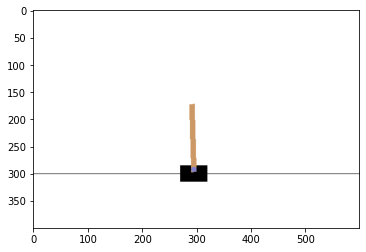

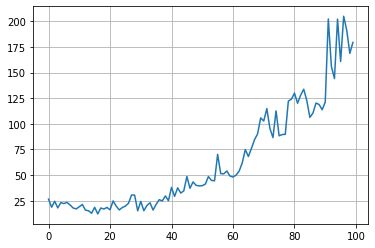

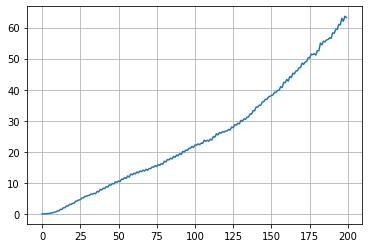

In [ ]:
cart_pole_env = gym.make("CartPole-v1")
cart_pole_env.reset()
plt.imshow(cart_pole_env.render("rgb_array"))

run_agents(cart_pole_env, 9, 100, compile_dqn, 1.0, 0.0008)

In [ ]:
import numpy as np
from gym.spaces.box import Box
from gym.core import Wrapper

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4):
        super(FrameBuffer, self).__init__(env)
        height, width, n_channels = env.observation_space.shape
        obs_shape = [height, width, n_channels * n_frames]

        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        offset = self.env.observation_space.shape[-1]
        axis = -1
        cropped_framebuffer = self.framebuffer[:, :, :-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)

In [ ]:
from gym.core import ObservationWrapper
from gym.spaces import Box

import cv2
from skimage.color import rgb2gray
from skimage import img_as_float


class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        ObservationWrapper.__init__(self, env)
        self.img_size = (64, 64, 1)
        self.observation_space = Box(0.0, 1.0, self.img_size)

    def observation(self, img):
        img = img[50:-5,5:-5]
        img = cv2.resize(img, (64, 64))
        img = rgb2gray(img)
        img = np.expand_dims(img, -1)
        img = img_as_float(img)
        img = np.float32(img)
        return img

(64, 64, 4)
game  1 score:  0.0 epsilon:  0.5
game  2 score:  2.0 epsilon:  0.5
game  3 score:  2.0 epsilon:  0.5
game  4 score:  3.0 epsilon:  0.5
game  5 score:  2.0 epsilon:  0.5
game  6 score:  3.0 epsilon:  0.5
game  7 score:  0.0 epsilon:  0.5
game  8 score:  0.0 epsilon:  0.5
game  9 score:  1.0 epsilon:  0.5
game  10 score:  0.0 epsilon:  0.5
game  11 score:  0.0 epsilon:  0.5
game  12 score:  0.0 epsilon:  0.5
game  13 score:  0.0 epsilon:  0.5
game  14 score:  0.0 epsilon:  0.5
game  15 score:  2.0 epsilon:  0.5
game  16 score:  0.0 epsilon:  0.5
game  17 score:  2.0 epsilon:  0.5
game  18 score:  2.0 epsilon:  0.5
game  19 score:  4.0 epsilon:  0.5
game  20 score:  2.0 epsilon:  0.5
game  21 score:  0.0 epsilon:  0.5
game  22 score:  0.0 epsilon:  0.5
game  23 score:  1.0 epsilon:  0.5
game  24 score:  0.0 epsilon:  0.5
game  25 score:  1.0 epsilon:  0.5
game  26 score:  1.0 epsilon:  0.5
game  27 score:  1.0 epsilon:  0.5
game  28 score:  1.0 epsilon:  0.5
game  29 score:  

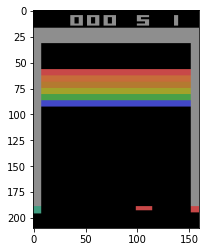

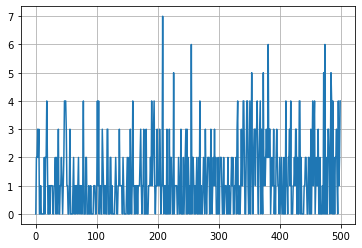

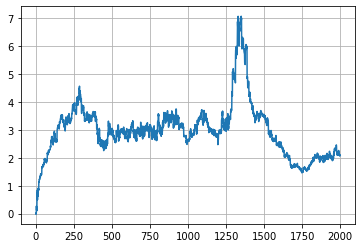

In [ ]:
breakout_env = gym.make("Breakout-v0")
breakout_env = PreprocessAtari(breakout_env)
breakout_env = FrameBuffer(breakout_env, n_frames=4)
s = breakout_env.reset()
print(s.shape)
plt.imshow(breakout_env.render("rgb_array"))

run_agents(breakout_env, 1, 500, compile_conv_dqn, 0.5, 0)

game  1 score:  0.0 epsilon:  0.5
game  2 score:  0.0 epsilon:  0.5
game  3 score:  0.0 epsilon:  0.5
game  4 score:  0.0 epsilon:  0.5
game  5 score:  0.0 epsilon:  0.5
game  6 score:  0.0 epsilon:  0.5
game  7 score:  0.0 epsilon:  0.5
game  8 score:  0.0 epsilon:  0.5
game  9 score:  0.0 epsilon:  0.5
game  10 score:  0.0 epsilon:  0.5
game  11 score:  0.0 epsilon:  0.5
game  12 score:  0.0 epsilon:  0.5
game  13 score:  0.0 epsilon:  0.5
game  14 score:  0.0 epsilon:  0.5
game  15 score:  0.0 epsilon:  0.5
game  16 score:  0.0 epsilon:  0.5
game  17 score:  0.0 epsilon:  0.5
game  18 score:  0.0 epsilon:  0.5
game  19 score:  0.0 epsilon:  0.5
game  20 score:  0.0 epsilon:  0.5
game  21 score:  0.0 epsilon:  0.5
game  22 score:  0.0 epsilon:  0.5
game  23 score:  0.0 epsilon:  0.5
game  24 score:  0.0 epsilon:  0.5
game  25 score:  0.0 epsilon:  0.5
game  26 score:  0.0 epsilon:  0.5
game  27 score:  0.0 epsilon:  0.5
game  28 score:  0.0 epsilon:  0.5
game  29 score:  0.0 epsilon:

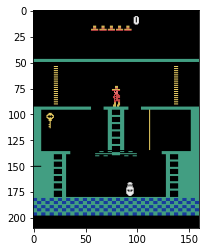

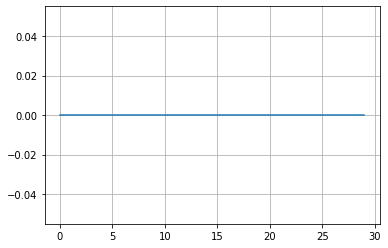

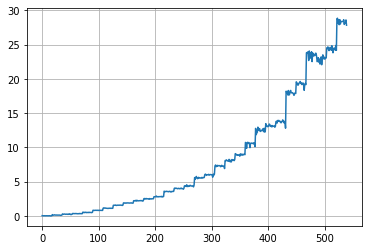

In [ ]:
motezuma_revenge_env = gym.make("MontezumaRevenge-v0")
motezuma_revenge_env = PreprocessAtari(motezuma_revenge_env)
motezuma_revenge_env = FrameBuffer(motezuma_revenge_env, n_frames=4)
s = motezuma_revenge_env.reset()
plt.imshow(motezuma_revenge_env.render("rgb_array"))

run_agents(motezuma_revenge_env, 1, 30, compile_conv_dqn, 0.5, 0.0)